## Практическое задание 6. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm
import catboost
import time

from sklearn.model_selection import train_test_split, KFold, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, precision_recall_curve
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve

__Задание 1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data).  

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [2]:
data = pd.read_csv("application_train.csv")
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
Y = np.array(data["TARGET"])
X = data.drop(columns=["TARGET", "SK_ID_CURR"])

In [4]:
columns = X.dtypes
columns_category = columns[columns == "object"].index.tolist()
columns_nums = columns[columns != "object"].index.tolist()
X[columns_category] = X[columns_category].fillna(' ')
X[columns_nums] = X[columns_nums].fillna(0.0)

In [5]:
for name in X.columns:
    if X[name].dtypes == "object":
        X[name] = X[name].astype("category")

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, random_state=0)
X_train.shape, X_test.shape

((215257, 120), (92254, 120))

__Задание 2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [7]:
def metric(model_test, X, Y, ax, name, style):
    precision, recall, thresholds = precision_recall_curve(Y, model_test.predict_proba(X)[:,1])
    pr = average_precision_score(Y, model_test.predict_proba(X)[:,1])
    ax[0].plot(recall, precision, label=f"PR {name} =" + str(pr), linestyle=style)
    ax[0].set_ylabel('Precision')
    ax[0].set_xlabel('Recall')
    
    ax[0].legend()
    
    fpr, tpr, thresholds = roc_curve(Y, model_test.predict_proba(X)[:,1])
    auc = roc_auc_score(Y, model_test.predict_proba(X)[:,1])
    
    ax[1].plot(fpr, tpr, label=f"AUC {name} =" + str(auc), linestyle=style)
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlabel('False Positive Rate')
    
    ax[1].legend()

Время работы lightgbm = 4.6
Время работы catboost = 17.2


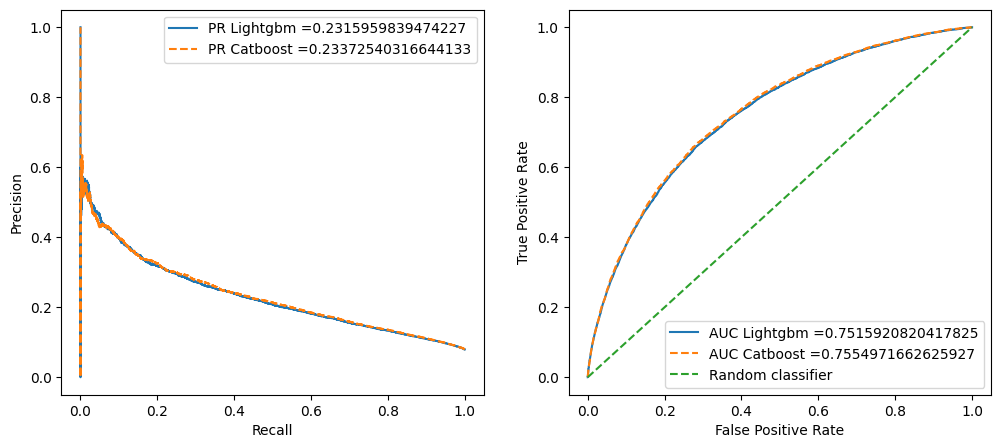

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

start = time.time()
model = lightgbm.LGBMClassifier(device = "gpu", verbose_eval=False, verbosity=-1)
model.fit(X_train[columns_nums], Y_train)
print(f"Время работы lightgbm = {round(time.time() - start, 2)}")

metric(model, X_test[columns_nums], Y_test, ax, "Lightgbm", "-")

start = time.time()
model = catboost.CatBoostClassifier(task_type='GPU', verbose=0)
model.fit(X_train[columns_nums], Y_train)
print(f"Время работы catboost = {round(time.time() - start, 2)}")

metric(model, X_test[columns_nums], Y_test, ax, "Catboost", "--")

ax[1].plot([0, 1], [0, 1], "--", label='Random classifier') 
ax[1].legend()

**Вывод:** Точность моделей почти одинаковая, время работы часто получается разным, сложно что-то про него сказать

__Задание 3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [9]:
params_lightgbm = {'max_depth': [2, 3, 5],
                   'n_estimators': np.linspace(1000, 2000, 3, dtype=np.int32),
                   'learning_rate': [0.05, 0.1, 0.5],
                   'objective': ["binary", "cross_entropy"]}

params_catboost = {'depth': [3, 5, 7],
                   'iterations': np.linspace(1000, 2000, 3, dtype=np.int32),
                   'learning_rate': [0.05, 0.1, 0.5],
                   'loss_function': ["Logloss", "CrossEntropy"]}

In [10]:
start = time.time()
model = lightgbm.LGBMClassifier(verbose_eval=False, verbosity=-1)

cv = KFold(n_splits=3, shuffle=True, random_state=42)

searcher = GridSearchCV(model, param_grid=params_lightgbm, scoring='average_precision', cv=cv)
searcher.fit(X[columns_nums], Y)

print(f"Время подбора параметров lightgbm = {round(time.time() - start, 2)}")


best_params_lightgbm = searcher.best_params_


start = time.time()
model = catboost.CatBoostClassifier(task_type='GPU', verbose=0)

cv = KFold(n_splits=3, shuffle=True, random_state=42)

searcher = GridSearchCV(model, param_grid=params_catboost, scoring='average_precision', cv=cv)
searcher.fit(X[columns_nums], Y)

print(f"Время подбора параметров catboost = {round(time.time() - start, 2)}")

best_params_catboost = searcher.best_params_

Время подбора параметров lightgbm = 1335.2
Время подбора параметров catboost = 1610.85


**Вывод:** лучшие параметры для catboost и lightgbm

In [11]:
print("Best_params_lightgbm:")
best_params_lightgbm

Best_params_lightgbm:


{'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 1500,
 'objective': 'binary'}

In [12]:
print("Best_params_catboost:")
best_params_catboost

Best_params_catboost:


{'depth': 5,
 'iterations': 1500,
 'learning_rate': 0.05,
 'loss_function': 'CrossEntropy'}

Время работы lightgbm = 45.65
Время работы catboost = 9.55


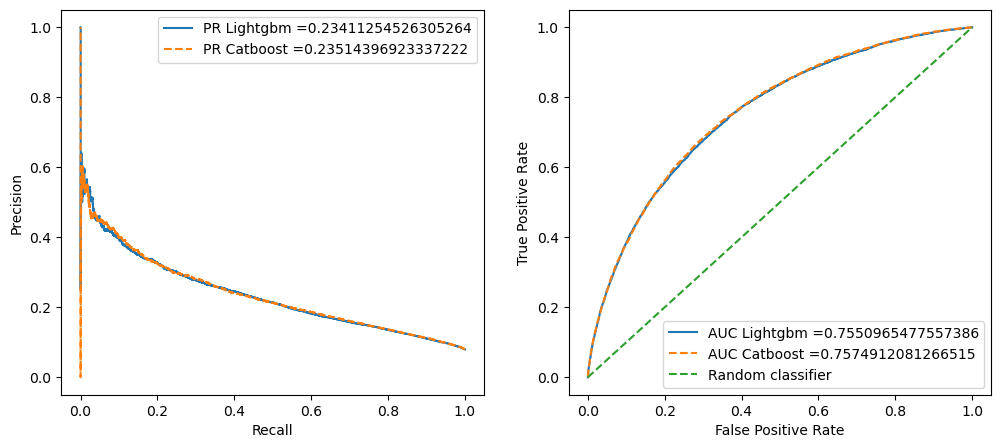

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

start = time.time()
model = lightgbm.LGBMClassifier(device = "gpu",
                                verbose_eval=False,
                                verbosity=-1,
                                learning_rate=0.05,
                                max_depth=3,
                                n_estimators=1500,
                                objective='binary')

model.fit(X_train[columns_nums], Y_train)
print(f"Время работы lightgbm = {round(time.time() - start, 2)}")

metric(model, X_test[columns_nums], Y_test, ax, "Lightgbm", "-")

start = time.time()
model = catboost.CatBoostClassifier(task_type='GPU',
                                    verbose=0,
                                    depth=5,
                                    iterations=1500,
                                    learning_rate=0.05,
                                    loss_function='CrossEntropy')

model.fit(X_train[columns_nums], Y_train)
print(f"Время работы catboost = {round(time.time() - start, 2)}")

metric(model, X_test[columns_nums], Y_test, ax, "Catboost", "--")

ax[1].plot([0, 1], [0, 1], "--", label='Random classifier') 
ax[1].legend()

**Вывод:** при гиперпараметрах качество изменилось несущественно

__Задание 4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [65]:
import re

In [66]:
X_OHE = pd.get_dummies(X)
X_train_OHE, X_test_OHE = train_test_split(X_OHE, train_size=0.7, random_state=0)

In [67]:
columns = X_OHE.dtypes
columns_uint8 = columns[columns == "uint8"].index.tolist()

X_OHE[columns_uint8] = X_OHE[columns_uint8].astype(int)
X_train_OHE[columns_uint8] = X_train_OHE[columns_uint8].astype(int)
X_test_OHE[columns_uint8] = X_test_OHE[columns_uint8].astype(int)

X_OHE = X_OHE.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_train_OHE = X_train_OHE.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_OHE = X_test_OHE.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [17]:
start = time.time()
model = lightgbm.LGBMClassifier(verbose_eval=False, verbosity=-1)

cv = KFold(n_splits=3, shuffle=True, random_state=42)

searcher = GridSearchCV(model, param_grid=params_lightgbm, cv=cv)
searcher.fit(X_OHE, Y)

print(f"Время работы lightgbm_OHE = {round(time.time() - start, 2)}")

best_params_lightgbm_OHE = searcher.best_params_

Время работы lightgbm_OHE = 1591.41


In [18]:
start = time.time()
model = catboost.CatBoostClassifier(task_type='GPU', verbose=0)

cv = KFold(n_splits=3, shuffle=True, random_state=42)

searcher = GridSearchCV(model, param_grid=params_catboost, cv=cv)
searcher.fit(X_OHE, Y)

print(f"Время работы catboost_OHE = {round(time.time() - start, 2)}")

best_params_catboost_OHE = searcher.best_params_

Время работы catboost_OHE = 1659.66


**Вывод:** лучшие параметры для OHE

In [19]:
best_params_lightgbm_OHE

{'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 1000,
 'objective': 'binary'}

In [20]:
best_params_catboost_OHE

{'depth': 5,
 'iterations': 1000,
 'learning_rate': 0.05,
 'loss_function': 'CrossEntropy'}

Время работы lightgbm = 31.36
Время работы catboost = 7.03


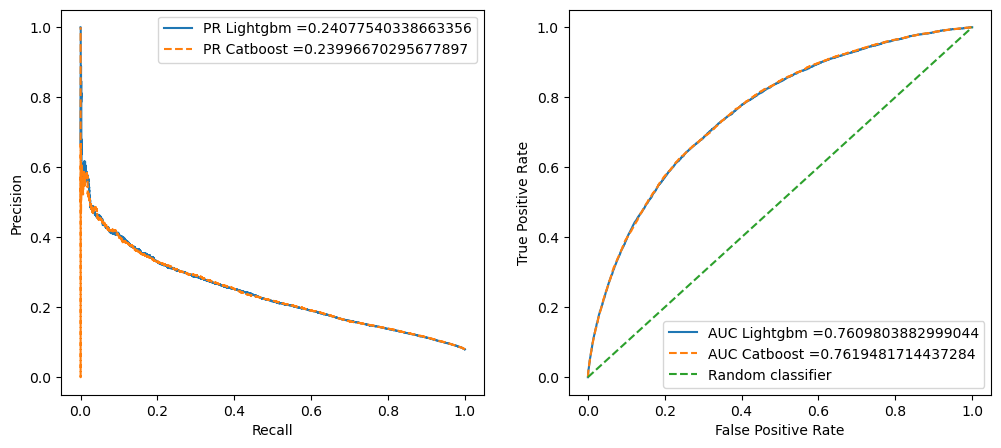

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

start = time.time()
model = lightgbm.LGBMClassifier(device = "gpu",
                                verbose_eval=False,
                                verbosity=-1,
                                learning_rate=0.05,
                                max_depth=3,
                                n_estimators=1000,
                                objective='binary')

model.fit(X_train_OHE, Y_train)
print(f"Время работы lightgbm = {round(time.time() - start, 2)}")

metric(model, X_test_OHE, Y_test, ax, "Lightgbm", "-")

start = time.time()
model = catboost.CatBoostClassifier(task_type='GPU',
                                    verbose=0,
                                    depth=5,
                                    iterations=1000,
                                    learning_rate=0.05,
                                    loss_function='CrossEntropy')

model.fit(X_train_OHE, Y_train)
print(f"Время работы catboost = {round(time.time() - start, 2)}")

metric(model, X_test_OHE, Y_test, ax, "Catboost", "--")

ax[1].plot([0, 1], [0, 1], "--", label='Random classifier') 
ax[1].legend()

**Вывод:** при использовании ОНЕ, качество слегка возросло

In [22]:
start = time.time()
model = lightgbm.LGBMClassifier(verbose_eval=False, verbosity=-1)

cv = KFold(n_splits=3, shuffle=True, random_state=42)

searcher = GridSearchCV(model, param_grid=params_lightgbm, cv=cv)
searcher.fit(X, Y, categorical_feature=columns_category)

print(f"Время работы lightgbm model encoding  = {round(time.time() - start, 2)}")

best_params_lightgbm_model_encoding = searcher.best_params_

Время работы lightgbm model encoding  = 1543.88


In [70]:
import category_encoders as ce 

cbe_encoder = ce.cat_boost.CatBoostEncoder() 

cbe_encoder.fit(X, Y)
X_cat_boost_encoder = cbe_encoder.transform(X)
X_train_cat_boost_encoder = cbe_encoder.transform(X_train)
X_test_cat_boost_encoder = cbe_encoder.transform(X_test) 

In [24]:
start = time.time()
model = catboost.CatBoostClassifier(task_type='GPU', verbose=0)

cv = KFold(n_splits=3, shuffle=True, random_state=42)

searcher = GridSearchCV(model, param_grid=params_catboost, cv=cv)
searcher.fit(X_cat_boost_encoder, Y)

print(f"Время работы catboost model encoding = {round(time.time() - start, 2)}")

best_params_catboost_model_encoding = searcher.best_params_

Время работы catboost model encoding = 1637.08


**Вывод:** лучшие параметры, когда категориальные признаки преобразовывала сама модель

In [25]:
best_params_lightgbm_model_encoding

{'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 2000,
 'objective': 'binary'}

In [26]:
best_params_catboost_model_encoding

{'depth': 5,
 'iterations': 1000,
 'learning_rate': 0.05,
 'loss_function': 'Logloss'}

Время работы lightgbm = 53.97
Время работы catboost = 6.38


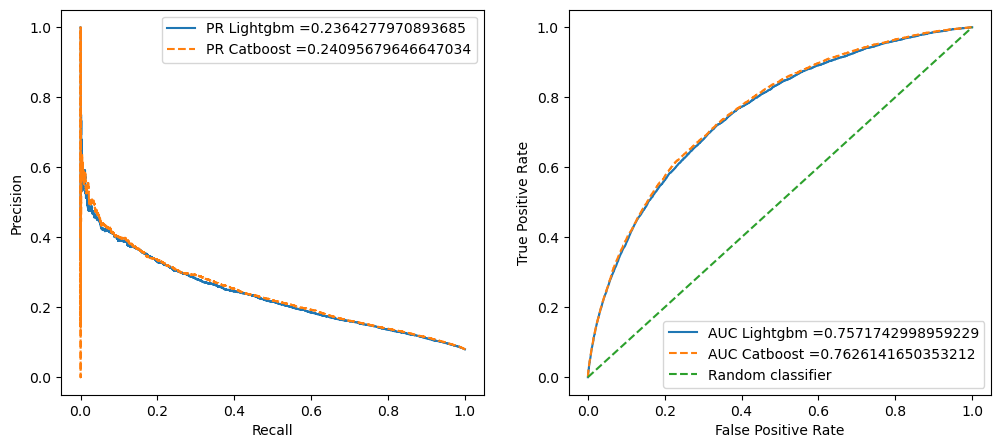

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

start = time.time()
model = lightgbm.LGBMClassifier(device = "gpu",
                                verbose_eval=False,
                                verbosity=-1,
                                learning_rate=0.05,
                                max_depth=3,
                                n_estimators=2000,
                                objective='binary')

model.fit(X_train, Y_train, categorical_feature=columns_category)
print(f"Время работы lightgbm = {round(time.time() - start, 2)}")

metric(model, X_test, Y_test, ax, "Lightgbm", "-")

start = time.time()
model = catboost.CatBoostClassifier(task_type='GPU',
                                    verbose=0,
                                    depth=5,
                                    iterations=1000,
                                    learning_rate=0.05,
                                    loss_function='Logloss')

model.fit(X_train_cat_boost_encoder, Y_train)
print(f"Время работы catboost = {round(time.time() - start, 2)}")

metric(model, X_test_cat_boost_encoder, Y_test, ax, "Catboost", "--")

ax[1].plot([0, 1], [0, 1], "--", label='Random classifier') 
ax[1].legend()

**Вывод:** точность слегка ниже ОНЕ, но практически такая же 

__Задание 5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [68]:
predict_lightgbm = 0
model = lightgbm.LGBMClassifier(device = "gpu",
                                verbose_eval=False,
                                verbosity=-1,
                                learning_rate=0.05,
                                max_depth=3,
                                n_estimators=1000,
                                objective='binary')

model.fit(X_train_OHE, Y_train)
predict_lightgbm += model.predict_proba(X_test_OHE)[:,1]

predict_catboost = 0
model = catboost.CatBoostClassifier(task_type='GPU',
                                    verbose=0,
                                    depth=5,
                                    iterations=1000,
                                    learning_rate=0.05,
                                    loss_function='CrossEntropy')

model.fit(X_train_OHE, Y_train)
predict_catboost += model.predict_proba(X_test_OHE)[:,1]

In [71]:
model = lightgbm.LGBMClassifier(device = "gpu",
                                verbose_eval=False,
                                verbosity=-1,
                                learning_rate=0.05,
                                max_depth=3,
                                n_estimators=1000,
                                objective='binary')

model.fit(X_train, Y_train, categorical_feature=columns_category)

predict_lightgbm += model.predict_proba(X_test)[:,1]

model = catboost.CatBoostClassifier(task_type='GPU',
                                    verbose=0,
                                    depth=5,
                                    iterations=1000,
                                    learning_rate=0.05,
                                    loss_function='Logloss')

model.fit(X_train_cat_boost_encoder, Y_train)

predict_catboost += model.predict_proba(X_test_cat_boost_encoder)[:,1]

In [72]:
model = lightgbm.LGBMClassifier(device = "gpu",
                                verbose_eval=False,
                                verbosity=-1,
                                learning_rate=0.05,
                                max_depth=3,
                                n_estimators=1500,
                                objective='binary')

model.fit(X_train[columns_nums], Y_train)

predict_lightgbm += model.predict_proba(X_test[columns_nums])[:,1]

model = catboost.CatBoostClassifier(task_type='GPU',
                                    verbose=0,
                                    depth=5,
                                    iterations=1500,
                                    learning_rate=0.05,
                                    loss_function='CrossEntropy')

model.fit(X_train[columns_nums], Y_train)

predict_catboost += model.predict_proba(X_test[columns_nums])[:,1]

In [73]:
predict_lightgbm /= 3
predict_catboost /= 3

print("lightgbm -", average_precision_score(Y_test, predict_lightgbm))
print("сatboost -", average_precision_score(Y_test, predict_catboost))

lightgbm - 0.24070617086021595
сatboost - 0.24179289136920926


In [74]:
print("lightgbm -", roc_auc_score(Y_test, predict_lightgbm))
print("сatboost -", roc_auc_score(Y_test, predict_catboost))

lightgbm - 0.7614010158314368
сatboost - 0.762763169776069


**Вывод:** точность как на OHE

__Задание 6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

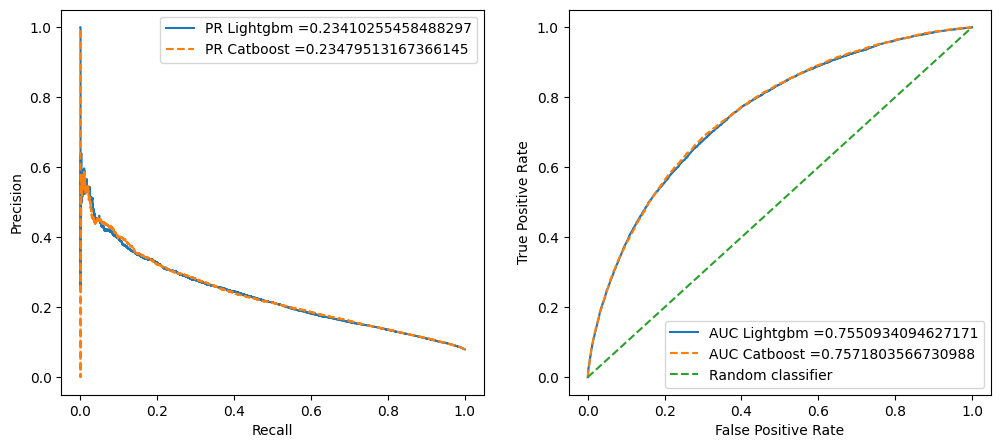

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

start = time.time()
model_lightgbm = lightgbm.LGBMClassifier(device = "cpu",
                                verbose_eval=False,
                                verbosity=-1,
                                learning_rate=0.05,
                                max_depth=3,
                                n_estimators=1500,
                                objective='binary')

model_lightgbm.fit(X_train[columns_nums], Y_train)

metric(model_lightgbm, X_test[columns_nums], Y_test, ax, "Lightgbm", "-")


model_catboost = catboost.CatBoostClassifier(task_type='GPU',
                                    verbose=0,
                                    depth=5,
                                    iterations=1500,
                                    learning_rate=0.05,
                                    loss_function='CrossEntropy')

model_catboost.fit(X_train[columns_nums], Y_train)

metric(model_catboost, X_test[columns_nums], Y_test, ax, "Catboost", "--")

ax[1].plot([0, 1], [0, 1], "--", label='Random classifier') 
ax[1].legend()

Всего признаков 104


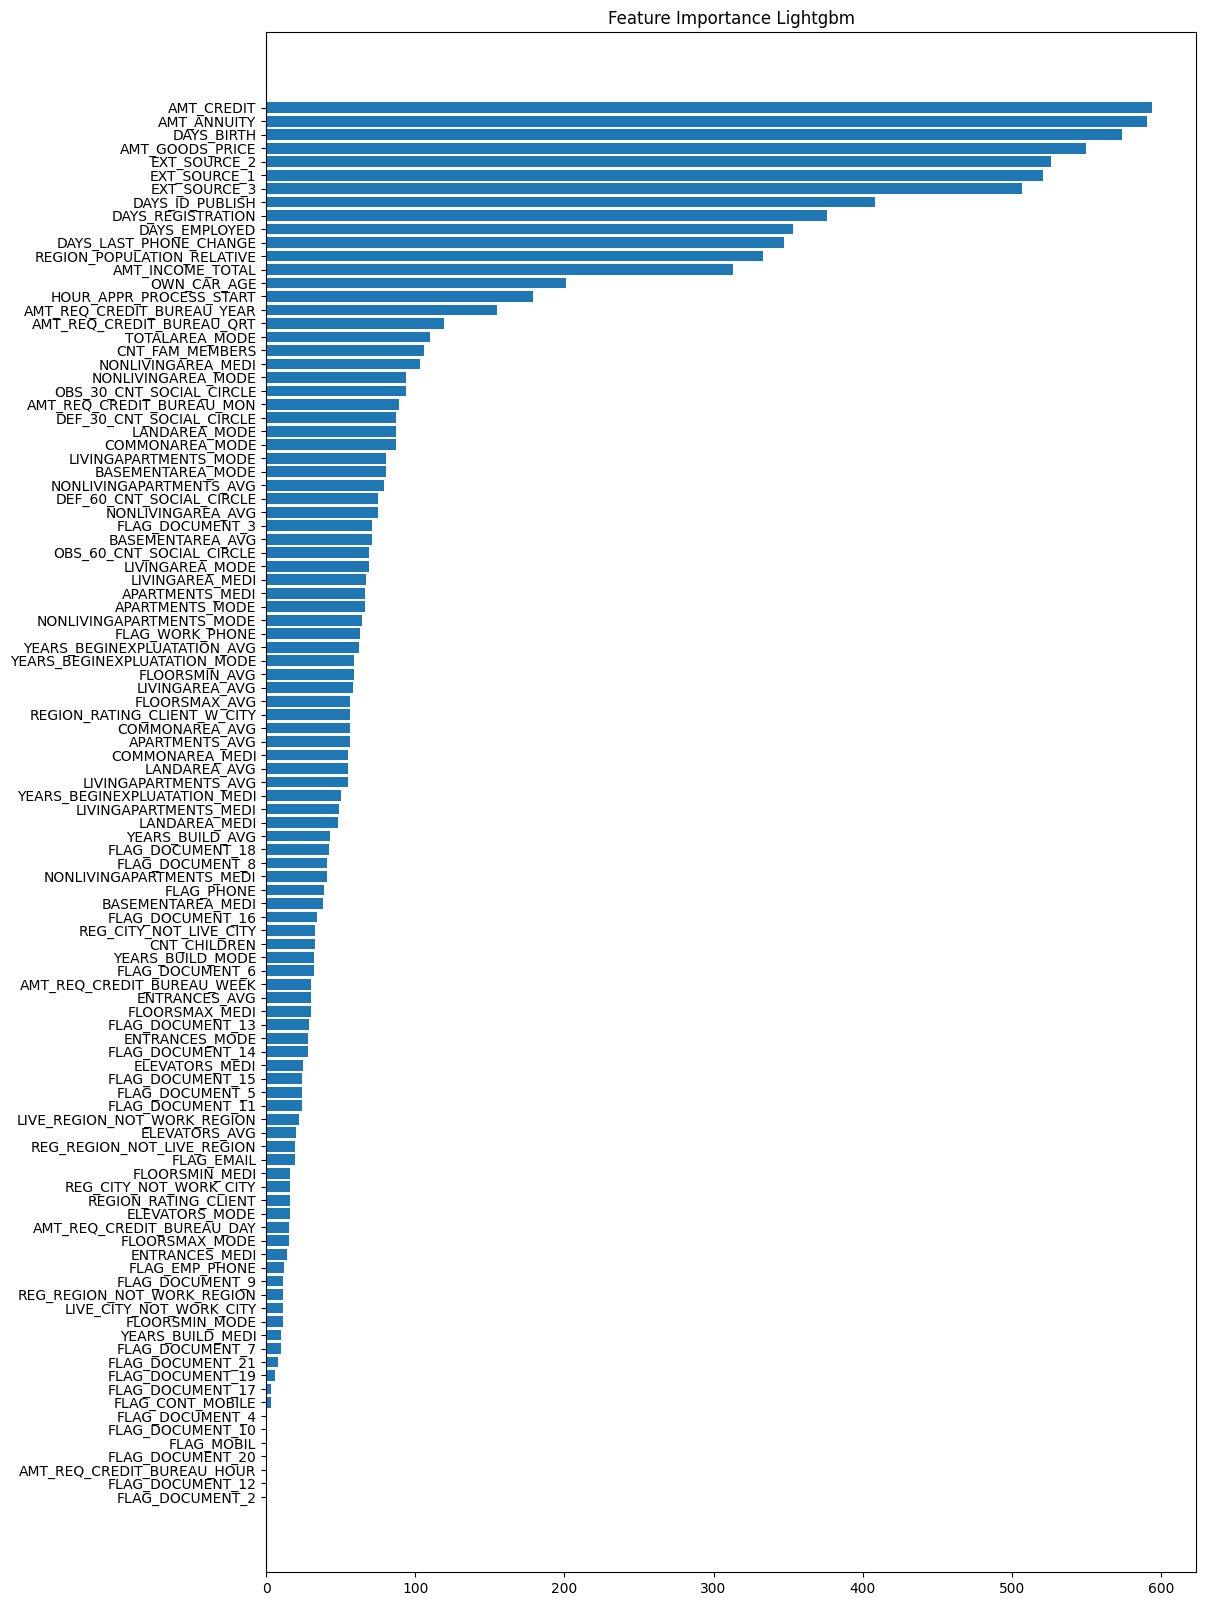

In [35]:
feature_importance_lightgbm = model_lightgbm.feature_importances_
sorted_idx = np.argsort(feature_importance_lightgbm)
feature_importance_lightgbm = feature_importance_lightgbm[sorted_idx]
feature_importance_lightgbm_name = np.array(X_train[columns_nums].columns[sorted_idx])

fig = plt.figure(figsize=(12, 20))
plt.barh(range(len(sorted_idx)), feature_importance_lightgbm, align='center')
plt.yticks(range(len(sorted_idx)), feature_importance_lightgbm_name)
plt.title('Feature Importance Lightgbm')
print(f'Всего признаков {len(feature_importance_lightgbm)}')

Text(0.5, 1.0, 'Feature Importance Catboost')

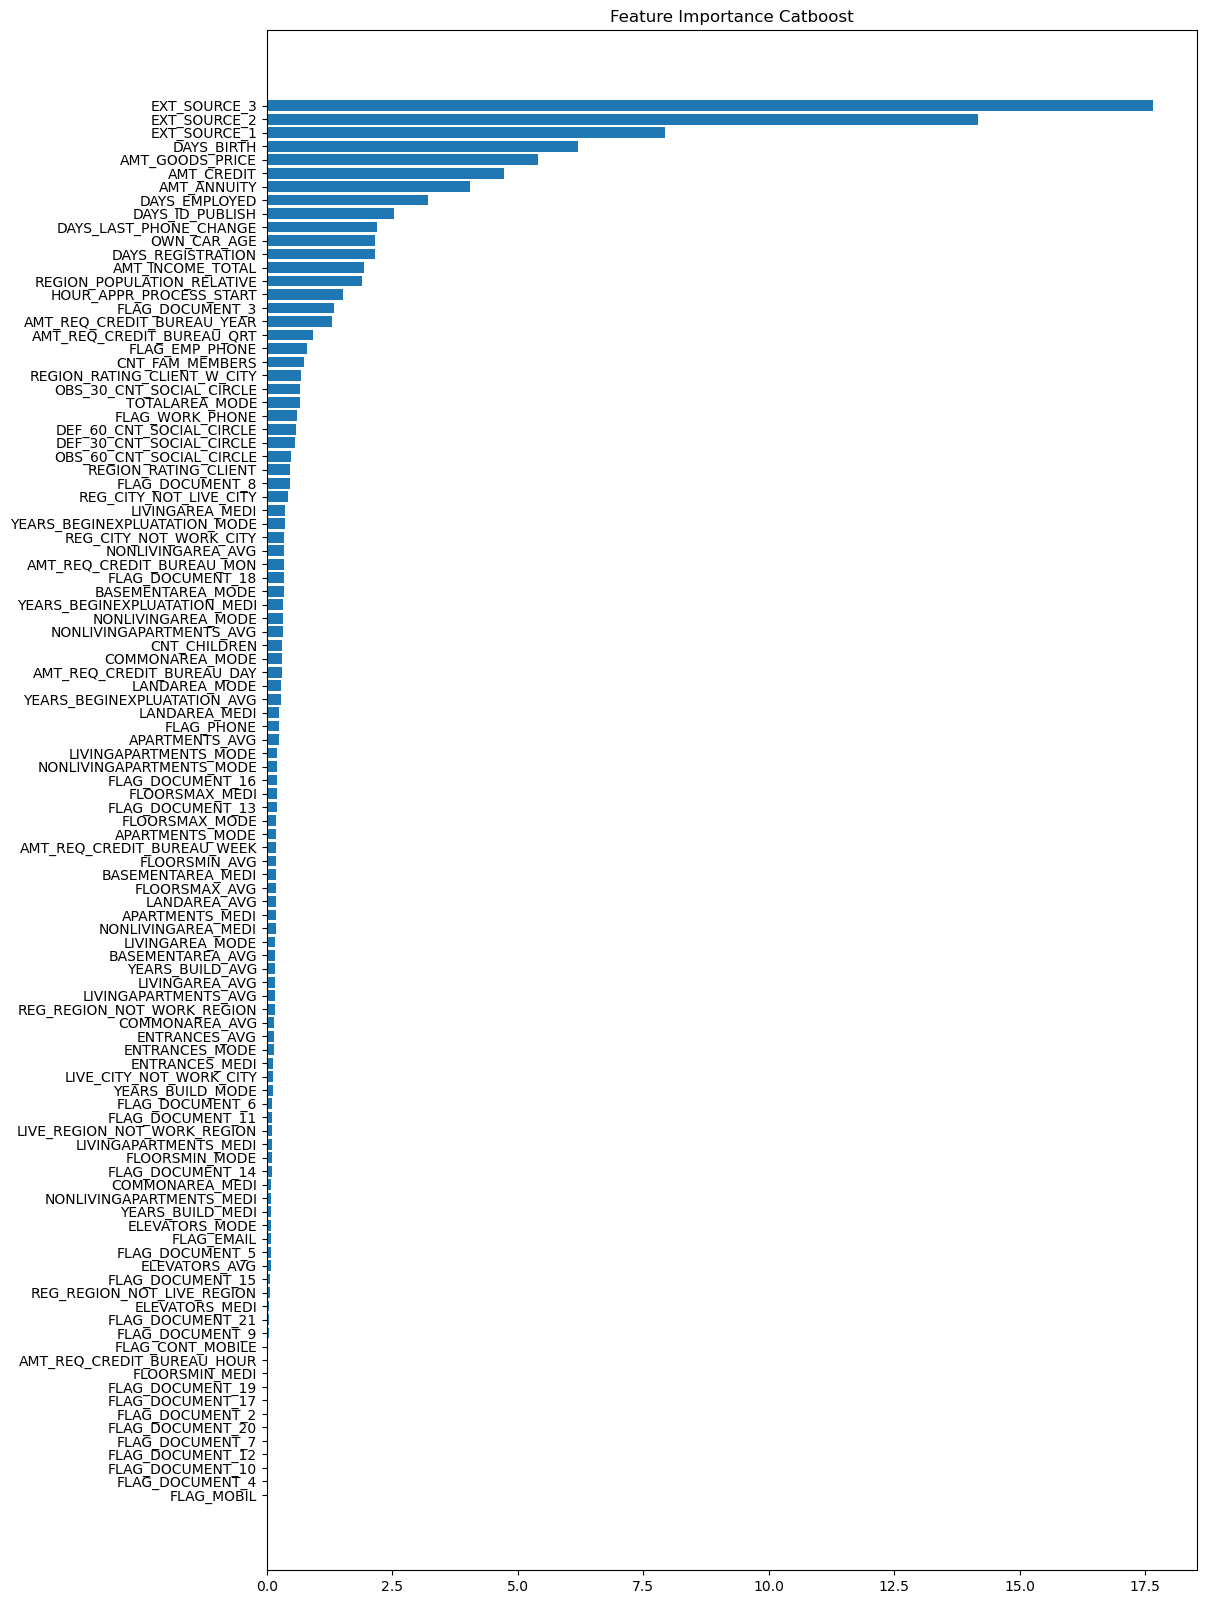

In [36]:
feature_importance_catboost = model_catboost.feature_importances_
sorted_idx = np.argsort(feature_importance_catboost)
feature_importance_catboost = feature_importance_catboost[sorted_idx]
feature_importance_catboost_name = np.array(X_train[columns_nums].columns[sorted_idx])

fig = plt.figure(figsize=(12, 20))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_importance_catboost_name)
plt.title('Feature Importance Catboost')

In [37]:
feature_importance_lightgbm_name = feature_importance_lightgbm_name[79:]
feature_importance_catboost_name = feature_importance_catboost_name[79:]

print(f"Кол-во главных признаков = {len(feature_importance_lightgbm_name)}")

Кол-во главных признаков = 25


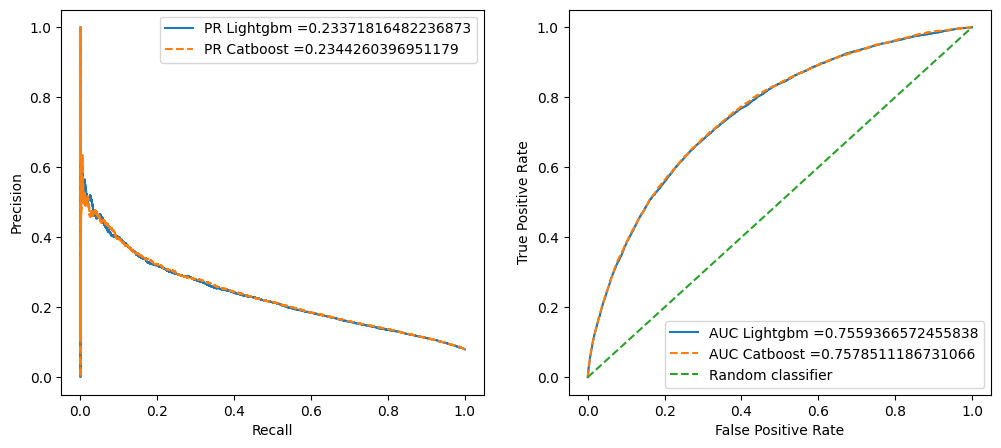

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

start = time.time()
model_lightgbm = lightgbm.LGBMClassifier(device = "cpu",
                                verbose_eval=False,
                                verbosity=-1,
                                learning_rate=0.05,
                                max_depth=3,
                                n_estimators=1500,
                                objective='binary')

model_lightgbm.fit(X_train[feature_importance_lightgbm_name], Y_train)

metric(model_lightgbm, X_test[feature_importance_lightgbm_name], Y_test, ax, "Lightgbm", "-")


model_catboost = catboost.CatBoostClassifier(task_type='GPU',
                                    verbose=0,
                                    depth=5,
                                    iterations=1500,
                                    learning_rate=0.05,
                                    loss_function='CrossEntropy')

model_catboost.fit(X_train[feature_importance_catboost_name], Y_train)

metric(model_catboost, X_test[feature_importance_catboost_name], Y_test, ax, "Catboost", "--")

ax[1].plot([0, 1], [0, 1], "--", label='Random classifier') 
ax[1].legend()

**Вывод:** при 25 признаках качество не стало хуже